<a href="https://colab.research.google.com/github/tiashamondal29/Spotify-song-popularity-and-Genres-prediction/blob/main/Spotify_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Regression: predict song popularity. 

This dataset includes these features:  
**Id**: unique track identifier.  
**title**: track title.  
**artist**: singer or band.  
**year**:  year of release (or re-release).  
**bpm**:  beats per minute.  
**nrgy**:  energy: higher, more energetic.  
**dnce**: danceability: higher, the easier to dance to.  
**dB**:  loudness (dB): the higher the value, the louder the song.  
**live**: liveness: higher, more likely it's a live recording.  
**val**: valence: higher, more positive mood.  
**dur**: duration: song length.  
**acous**: acousticness: higher, more acoustic.  
**spch**: speechiness: higher, more spoken word.  
**pop**:  popularity: higher is more popular.  
**top genre**:  genre of the track (class label).  

Spotify: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features  

Kaggle data: https://www.kaggle.com/cnic92/spotify-past-decades-songs-50s10s.  
There are 13 attributes in the dataset that can be used to build a model that predicts "popularity".

In [288]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [289]:
# default is 120 seconds
%autosave 60 

Autosaving every 60 seconds


# Load the data

Load the train and test data: the train data will be split into train and validation sets for hyperparameter tuning and to select the best model. The best model will be trained on the entire training set and used to make predictions using the test set.

In [290]:
# load dataset

dataset=pd.read_csv('RegressionTrain.csv')
test_dataset=pd.read_csv("RegressionTest.csv")

verbose=True   # for plots and verbose text output 

In [291]:
dataset.columns

Index(['Id', 'title', 'artist', 'top genre', 'year', 'bpm', 'nrgy', 'dnce',
       'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop'],
      dtype='object')

# EDA and Visualization

### Data summary
For this task our first step was to perform exporatory data analysis (EDA) and visualization.
**train_dataset.describe()** shows a summary of the numerical training data. 
The range of values for each feature appears to be valid. For example, the range 
for bpm is 62 to 199 with a mean and median close to 120bpm, which is considered to be 
optimal for song popularity.  **train_dataset.info()** shows that top genre 
is 15 missing values (453-438). Non-Null counts should be equal, rows with missing top genre values were replace by predictions made by a Logistic Regression (LR), shown in a section below. LR was more accurate than using the mode or with an instance based model such as K Nearest Neighbors (KNN). Next,  **value_counts() and plt.bar()** revealed 86 genres, only 1 or 2 examples for most genres, but 
that was not an issue because we were trying to predict a song popularity based mostly on numerical data.

### Correlation
Multicollinearity: where independent variables are strongly correlated. This can reduce model performance. The variation inflation factor (VIF) for each variable can be computed. If predictive features yield VIF values less than 5, then this would indicate that multicollinearity is not a problem. However, the ***VIF*** output below shows that bpm and dnce are over 20!

The correlation matrix below shows that dB and nrgy have the highest positively correlated features, val and dnce are second, while dnce and acoustics are the most negatively correlated. However, most of the features in this dataset have low correlation and, in fact, the application of PCA did not improve classification accuracy.

### Outliers
Next we used ***sns.boxplot()*** to reveal potential outliers. The default value for the whiskers is 1.5 standard deviations. The boxplots show that some features include data point far beyond the whiskers. While it's difficult to distinguish between significant data points and outliers (noise), we found that most values greater the 3 standards from the mean were noise. 

### Clusters
t-SNE can project higher dimensional data onto a 2D space such that points that are relatively close in high dimensional space are close in 2D space.  The t-SNE plot below indicates that the songs cluster in a nonrandom way and that there pattern that may be exploited for regression.

### What worked and what did not
Most of the things we tried made either a small incremental improvement or none.  Dropping attributes (columns) usually reduced pop prediction errors (increased RMSE). PCA made little difference. Tuning model hyperparameters made little difference. But one-hot encoding title, artist, year and genre had a positive although modest impact on regression accuracy, while dropping any of the features increased RMSE.


Data pre-processing (will be discussed after EDA and visualization.


## Data exploration

In [292]:
##copy of the original dataset
train_dataset = dataset.copy()
#creating a copy of the test dataset
test_df = test_dataset.copy()

### Distribution of song popularity

In [293]:
y_all = train_dataset["pop"]
value_counts=y_all.value_counts()
print("number of c:", len(value_counts))

number of c: 59


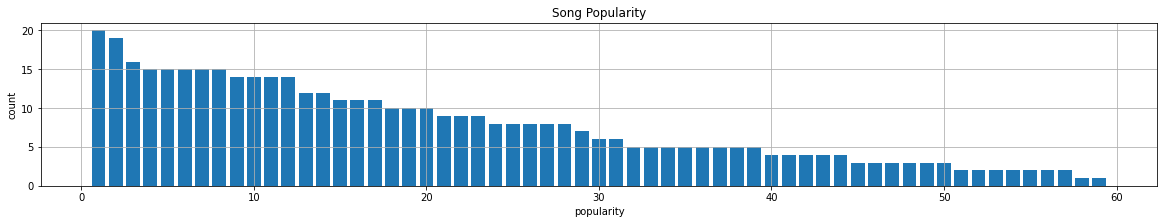

In [294]:
if verbose:
    num_bins=len(value_counts)
    
    x=[x for x in range(1,num_bins+1)]
    # full training set is very unbalanced, 
    # most genres have only 1 or 2 examples
    plt.figure(figsize=(20,3)) 
    value_counts.hist(bins=num_bins+1); 
    plt.bar(x, value_counts.values);
    #plt.xticks(rotation=90);
    plt.xlabel('popularity')
    plt.ylabel('count');
    plt.title('Song Popularity')

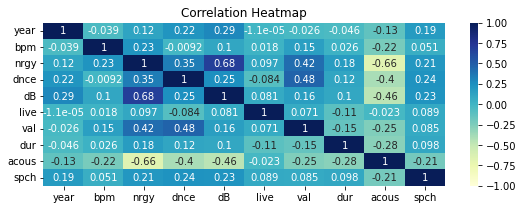

In [295]:
if verbose:
  # Plot linear correlation matrix
  cm_data=train_dataset.copy()
  cm=cm_data.iloc[:,1:14].corr()   # make sure indices are right!
  #cm[cm<0.45]=0

  fig, ax = plt.subplots(figsize=(9,3))
  sns.heatmap(cm, annot=True, cmap='YlGnBu', vmin=-1,
  vmax=1, center=0, ax=ax)
  plt.title('Correlation Heatmap')
  plt.show()

In [296]:
train_dataset

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,449,But Not For Me,Ella Fitzgerald,adult standards,1959,80,22,18,-17,10,16,214,92,4,45
449,450,Surf City,Jan & Dean,brill building pop,2010,148,81,53,-13,23,96,147,50,3,50
450,451,Dilemma,Nelly,dance pop,2002,168,55,73,-8,20,61,289,23,14,77
451,452,It's Gonna Be Me,*NSYNC,boy band,2000,165,87,64,-5,6,88,191,5,8,62


### VIF

We calculated the variance inflation factor for each feature. The equation: **VIF = 1/(1-R^2)** where R^2 is the coefficient of determination. In general, if a feature that has a VIF value greater than 5 is considered to be highly collinear with other features in the data.  The output below shows that bpm and dnce are over 20!  Unfortunately, carefully dropping some of these features to assess their impact on regression must be left to future work. 

In [297]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

num_data=train_dataset.iloc[:,5:14].copy()   # if this fails, the indices are wrong
VIF             = pd.DataFrame()
VIF['feature']  = num_data.columns
VIF['VIF']      = [variance_inflation_factor(num_data.values, i) for i in range(num_data.shape[1])]
VIF

,feature,VIF
0,bpm,20.145035
1,nrgy,19.446066
2,dnce,20.229727
3,dB,10.584092
4,live,2.708729
5,val,11.575961
6,dur,14.519625
7,acous,3.140740
8,spch,2.282084


### Boxplots show outliers

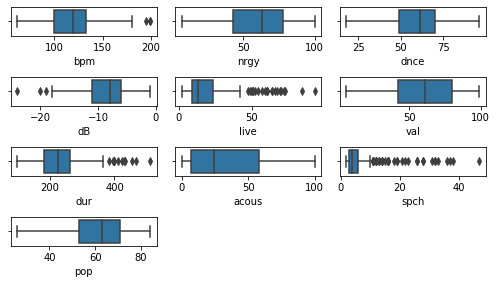

In [298]:
#boxplots: visualize data distributions and outliers
if verbose:
  plt.figure(figsize=(7,5));
  df=train_dataset.drop("top genre", axis=1, inplace=False)
  attributes=df.columns.values.tolist()
  idx=4
  for attribute in attributes[idx:]:
    plt.subplot(5,3,idx)
    sns.boxplot(x=train_dataset[attribute])
    idx=idx+1
  plt.tight_layout(pad=1)

### t-SNE shows some clustering in the training data

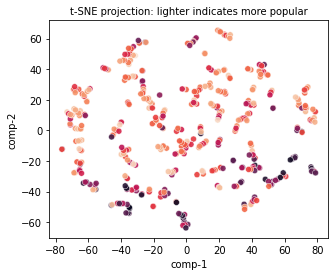

In [299]:
show_legend=False

# visualize training data
temp_data=dataset.copy()
#temp_data.dropna(axis=0, inplace=True)
temp_data.drop(['title','artist', 'top genre'], axis=1, inplace=True)
df = pd.DataFrame()
df["y"] = temp_data['pop'].copy();
y_pop=df["y"].sort_values(ascending=False)
#temp_data.drop(['pop'], axis=1, inplace=True)

if verbose:
  import numpy as np
  from sklearn.manifold import TSNE

  X_train_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(temp_data)
  X_train_embedded.shape
                
  df["comp-1"] = X_train_embedded[:,0]
  df["comp-2"] = X_train_embedded[:,1]
    
  # 59 unique pop scores, must be done after drop NA
  n_colors=len(df["y"].unique()) 
  plt.figure(figsize=(5,4));
  T=sns.scatterplot(x="comp-1", y="comp-2", hue=y_pop, legend=show_legend,\
                    palette=sns.color_palette("rocket", n_colors), \
                    data=df, alpha=.9);
  plt.title('t-SNE projection: lighter indicates more popular', fontsize=10)
    
  if show_legend:
    plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0);

# Data Pre Processing Steps on Train Set

### Building the training set such that it works with one-hot encoding

Based on data exporation and analysis, we decided to one-hot encode some of the categorical features on the theory that they comntained some information. Intuitively, we suspected that year is at least weakly associated with song popularity, while genre artist would be more strongly associated with popuarity.

In [300]:
# dropping the columns not required from train dataset
dataset = dataset.drop(["Id"], axis=1)
#dropping the pop column for test set
test_dataset = test_dataset.drop(["Id"], axis=1)

In [301]:
##copy of the original dataset
train_dataset = dataset.copy()

In [302]:
#creating pop in the test dataset
c = "pop"
test_dataset = test_dataset.assign(**{c: pd.Series(dtype='object')})

In [303]:
#concating the train and test dataset
concatenated_dataset = pd.concat([dataset, test_dataset])

In [304]:
#give the same column name as the original dataset 
concatenated_dataset = concatenated_dataset.reset_index(drop=True)
concatenated_dataset.columns= train_dataset.columns

In [305]:
if verbose:
    concatenated_dataset

In [306]:
#dividing the dataset into dependable and independent variables
x_con_data=concatenated_dataset.iloc[:,:-1]
y_con_data=concatenated_dataset.iloc[:,-1]

### One-hot encoding

In [307]:
#one hot encoding

# select the categorical variables
categorical_variables = ['title','artist','year']

# perform one hot encoding
x_con_data = pd.get_dummies(x_con_data, columns=categorical_variables)

In [308]:
#adding the pop in the one hot encoded dataset
x_con_data['pop'] = y_con_data
#assigning the data to the variable concatenated data
concatenated_dataset = x_con_data

In [309]:
if verbose:
    concatenated_dataset

### Split the concatenated dataset back into train and test sets.

In [310]:
# Manually specify the row index to split the dataset
split_index = train_dataset.shape[0]

# Split the dataset into two parts
dataset = concatenated_dataset.iloc[:split_index]
test_dataset = concatenated_dataset.iloc[split_index:]

# Print the size of the training and testing datasets
print(f"Training dataset size: {np.shape(dataset)}")
print(f"Testing dataset size: {np.shape(test_dataset)}")

Training dataset size: (453, 1048)
Testing dataset size: (114, 1048)


In [311]:
if verbose:
    dataset

In [312]:
if verbose:
    test_dataset

### Detect missing values and make records

In [313]:
#checking for null values in each columns in the dataset
print(dataset.iloc[:,:-1].isnull().any())
print(dataset.iloc[:,-1].isnull().any())

top genre     True
bpm          False
nrgy         False
dnce         False
dB           False
             ...  
year_2015    False
year_2016    False
year_2017    False
year_2018    False
year_2019    False
Length: 1047, dtype: bool
False


In [314]:
##copy of the genre dataset
genre_dataset = dataset[['top genre']]

In [315]:
from sklearn.model_selection import train_test_split
# Create a boolean mask of rows with missing values
mask = dataset.isnull().any(axis=1)

# Split the data into two sets: with and without missing values
test_set = dataset[mask]
train_set = dataset[~mask]

In [316]:
#extracting the pop column
pop_train=train_set["pop"]
pop_test=test_set["pop"]
pop = np.concatenate((pop_train,pop_test), axis=0)

# dropping the columns not required from train dataset
train_set = train_set.drop(["pop"], axis=1)
test_set = test_set.drop(["pop"], axis=1)

In [317]:
# Split the set without missing values into training and test sets
x_train = train_set.drop("top genre",axis=1)
y_train = train_set["top genre"]
x_test = test_set.drop("top genre",axis=1)
y_test = test_set["top genre"]

In [318]:
#copy of the x_train dataset
train_dataset = x_train.copy()

In [319]:
#checking for null values in x_train and y_train
if verbose:
    print(x_train.isnull().any())
    print(y_train.isnull().any())

bpm          False
nrgy         False
dnce         False
dB           False
live         False
             ...  
year_2015    False
year_2016    False
year_2017    False
year_2018    False
year_2019    False
Length: 1046, dtype: bool
False


In [320]:
#checking for null values in x_test and y_test
if verbose:
    print(x_test.isnull().any())
    print(y_test.isnull().any())

bpm          False
nrgy         False
dnce         False
dB           False
live         False
             ...  
year_2015    False
year_2016    False
year_2017    False
year_2018    False
year_2019    False
Length: 1046, dtype: bool
True


### Replace missing genre values with LR predicted genres
We used Logistic Regression to replace missing top genre values instead of KNN or dropping those rows. This was the most accurate method and it preserved the useful information contained in those rows.

In [321]:
#feature scaling of the training data
from sklearn.preprocessing import StandardScaler

x_train=x_train.values
x_test=x_test.values
# Scale the input data
scaler = StandardScaler()
x_train[:,:9] = scaler.fit_transform(x_train[:,:9])
x_test[:,:9] = scaler.transform(x_test[:,:9])

In [322]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and search space
params = {"C": [100], "penalty": ["l1"], "solver": ["liblinear"],"max_iter": [1000]}

# Create the logistic regression model
lr = LogisticRegression()

# Perform a grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lr, param_grid=params, cv=5)
grid_search.fit(x_train, y_train)

# Make predictions on the testing dataset
y_test = grid_search.predict(x_test)

In [323]:
#printing the predicted values of y_test

In [324]:
# Concatenate x_train and x_test along axis 0
x = np.concatenate((x_train, x_test), axis=0)
# Concatenate y_train and y_test along axis 0
y = np.concatenate((y_train, y_test), axis=0)

In [325]:
# Convert x_train and y_train to data frames
x = pd.DataFrame(x)
y = pd.DataFrame(y)


#assigning the same column name to the train datasets
y = y.reset_index(drop=True)
y.columns = genre_dataset.columns

x = x.reset_index(drop=True)
x.columns= train_dataset.columns

# Merge x_train and y_train along axis 1 (i.e., horizontally)
dataset = pd.concat([x ,y], axis=1)

In [326]:
# #adding the pop column back into the train dataset
dataset['pop'] = pop
#copy of the x_train dataset
train_dataset = dataset.copy()
#concating the train and test dataset
concatenated_dataset = pd.concat([dataset, test_dataset])
#give the same column name as the original dataset 
concatenated_dataset = concatenated_dataset.reset_index(drop=True)
concatenated_dataset.columns= train_dataset.columns
#concatenated_dataset
#dividing the dataset into dependable and independent variables
x_con_data=concatenated_dataset.iloc[:,:-1]
y_con_data=concatenated_dataset.iloc[:,-1]

### One-hot encoding

In [327]:
# select the categorical variables
categorical_variables = ['top genre']

# perform one hot encoding
x_con_data = pd.get_dummies(x_con_data, columns=categorical_variables)

In [328]:
#adding the top genre in the one hot encoded dataset
x_con_data['pop'] = y_con_data
#assigning the data to the variable concatenated data
concatenated_dataset = x_con_data

# Manually specify the row index to split the dataset
split_index = 453

# Split the dataset into two parts
dataset = concatenated_dataset.iloc[:split_index]
test_dataset = concatenated_dataset.iloc[split_index:]

# Print the size of the training and testing datasets
print(f"Training dataset size: {np.shape(dataset)}")
print(f"Testing dataset size: {np.shape(test_dataset)}")

Training dataset size: (453, 1145)
Testing dataset size: (114, 1145)


### Check for duplicates
One found and deleted.

In [329]:
# Check for duplicates
duplicates = dataset.duplicated().sum()
print(f"Number of duplicates: {duplicates}")
dataset = dataset.drop_duplicates()

Number of duplicates: 1


### Delete rows with outliers

In [330]:
# Define function to handle outliers using z-score method
def handle_outliers_z_score(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    df_out = df[(z_scores < threshold).all(axis=1)]
    return df_out



# Apply function to relevant columns
outliers_dataset = dataset.copy()
columns = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']
df_outliers_removed = handle_outliers_z_score(outliers_dataset[columns])
dataset = pd.concat([df_outliers_removed, dataset.drop(columns, axis=1) ], axis=1)
dataset = dataset.dropna()

# Print number of rows before and after handling outliers
print(f"Original number of rows: {len(outliers_dataset)}")
print(f"Number of rows after handling outliers: {len(dataset)}")

Original number of rows: 452
Number of rows after handling outliers: 409


In [331]:
#dividing the dataset into dependable and independent variables
X_train=dataset.iloc[:,:-1].values
Y_train=dataset.iloc[:,-1].values

# Train the models

In this section we trained the Linear Regression (LR), Support Vector Regression (SVR), and Random Forest Regressor (RFR) machine learning models on the training data. Support vector machines are well suited to small and medium sized complex data datasets. Random Forests and XGBoost known for excellent performance and we would try XGBoost in the future. Nonetheless, the quantity and quality (i.e. before and after pre-processing) of the dataset had a larger impact on performance than choice of model.

We used GridSearchCV to find the best hyperparameters and perform cross validation to identify the best model. We selected the best model based on root mean squared error (RMSE) on validation data. The three models delivered similar results, although the RFR model was relatively slow due to running many decision trees.  

Linear Regression (LR) was chosen as a benchmark and based on the idea that one should try a simple model first. Indeed, simple models are fast and often perform surprisngly well on tabluar data. It's training RMSE was virtually zero and yet it's best validation RMSE was about 11.057 and not signicantly different from SVR and RFR.  


SVR is a more complex model and we hoped that it would deliver a low RMSE. While SVR gets the best validation at the moment, the RMSE diffrence is small. The plot below shows that the validation RMSE is almost flat, i.e. decreasing regularization had little impact on RMSE.  The train RMSE mainatined a strong downward trajectory as C increased (and regularization decreased), a sign of overfitting.

RFR uses many decision tree estimators (can be hundreds) to predict real values. This model relies on the wisdom of crowds concept where many weak estimators combine to make accurate predictions. The number of estimators can be optimized, but we expected that ***max_depth*** would be the most imporatnt hyperparameter.  However, parameter tuning did not have a signicant impact on validation RMSE.

Please note: The RFR model in this notebook is currently giving high RMSE scores. The cause is unknown, but we were definitely getting validation a RMSE of ~7.5.

The train and validation plots for SVR are strikingly similar and their validation RMSE's are flat. It seems that our one-hot code dataset is not well suited to this regression task.  In contrast, we found that one-hot encoding greatly improved classification accuracy (in our other jupyter notebook).

Validation and selection were done prior running the model on the unseen test data for submission to Kaggle. While no Kaggle test data was used for training there was a risk that some test data information "leaked" into the training data because each Kaggle score could be used as feedback and influence model training decisions.

### Summary of final results
Utimately, our top scoring model on Kaggle was a RandomForest Regressor, with a RMSE of 7.44924.  Group name: Straw-hat Pirates, position 25 on the Kaggle leaderboard.

#### LR_model = LinearRegression(fit_intercept=True)
#### SVR_model = SVR(C=12, degree=2, kernel='rbf')
#### RF_model = RandomForestRegressor(n_estimators=300, max_depth=5)

Typical and reprodicible results are shown in this table and the plots below.

| Model | Train RMSE | Validation RMSE |
| --- | --- | --- |
| Linear Regression | ~0    | 11.057 |
| Support Vector Regression | 5.367 |  10.99 |
| Random Forest Regressor   | 7.137 |  11.280 |

## Linear Regression

In [332]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Create a linear regression model
model = LinearRegression()  # no random_state to set!

# Define the hyperparameters to tune and their values to test
param_grid = {'fit_intercept': [True]}

# Create a GridSearchCV object and fit it to the training data
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(best_params)
best_score = grid_search.best_score_

rmse_train = np.sqrt(-1*grid_search.cv_results_['mean_train_score'])
rmse_val = np.sqrt(-1* grid_search.cv_results_['mean_test_score'])

print("RMSE weighted train score={}".format(rmse_train))
print("RMSE weighted validation score={}".format(rmse_val))
print("best validation score={}".format(np.sqrt(-1*best_score)))

{'fit_intercept': True}
RMSE weighted train score=[6.4753585e-14]
RMSE weighted validation score=[11.55415994]
best validation score=11.554159935540143


In [333]:
# train on all training data, to run model on real test data
LR_model = LinearRegression(fit_intercept=True)
LR_model.fit(X_train, Y_train)

LinearRegression()

# Support Vector Regression (SVR)

In [334]:
from sklearn.svm import SVR
# Create an SVR model
svr_model = SVR( ) # no random state
# Define the hyperparameter grid to search over
param_grid = {'C': [1,2,3,4,5,6,7,8,9,10,11,12],'kernel': ['rbf'],
              'degree': [2]}

# Create a GridSearchCV object with the SVR model and hyperparameter grid
grid = GridSearchCV(svr_model, param_grid, scoring='neg_mean_squared_error',\
                    cv=5, return_train_score=True)
# Fit the GridSearchCV object to the training data
grid.fit(X_train, Y_train)
# Get the best hyperparameters
best_params = grid.best_params_
print("best params", best_params)
best_score = np.sqrt(-1 *grid.best_score_)

rmse_train= np.sqrt(-1 * grid.cv_results_['mean_train_score'])
rmse_val  = np.sqrt(-1 * grid.cv_results_['mean_test_score'])

print("RMSE weighted train score={}".format(rmse_train))
print("RMSE weighted validation score={}".format(rmse_val))
print("best validation score={}".format(best_score))

best params {'C': 12, 'degree': 2, 'kernel': 'rbf'}
RMSE weighted train score=[11.87837139 10.90055748 10.09059154  9.41079215  8.81310333  8.26968766
  7.77063971  7.30875856  6.87580136  6.46776874  6.08030191  5.71291569]
RMSE weighted validation score=[12.6024522  12.19543216 11.96666799 11.81665527 11.70631216 11.63148103
 11.56954948 11.52050268 11.48362395 11.45831952 11.43918918 11.42384359]
best validation score=11.423843588132994


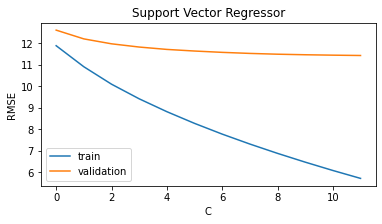

In [335]:
plt.figure(figsize=(6,3))
plt.plot(rmse_train, label="train")
plt.plot(rmse_val, label="validation")
plt.title("Support Vector Regressor")
plt.ylabel("RMSE")
plt.xlabel("C")
plt.legend();

In [336]:
# train on ful training set to run on Kaggle test data
SVR_model = SVR(C=best_params['C'], kernel=best_params['kernel'], \
                degree=best_params['degree'])
SVR_model.fit(X_train, Y_train)

SVR(C=12, degree=2)

In [337]:
y_train.shape

(438,)

## Random Forest Regressor

In [338]:
# train on all training data, to run model on real test data
from sklearn.ensemble import RandomForestRegressor

C_vec=np.arange(1,11,1)

rf_model = RandomForestRegressor(random_state=42)
# Define the hyperparameter grid to search over
param_grid = { 
    'n_estimators': [300],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11]
}

# Create a GridSearchCV object with the SVR model and hyperparameter grid
grid = GridSearchCV(rf_model, param_grid, scoring='neg_mean_squared_error',\
                    cv=5, return_train_score=True)
# Fit the GridSearchCV object to the training data
grid.fit(X_train, Y_train)
# Get the best hyperparameters
best_params = grid.best_params_
print("best params", best_params)

rmse_train= np.sqrt(-1 * grid.cv_results_['mean_train_score'])
rmse_val  = np.sqrt(-1 * grid.cv_results_['mean_test_score'])

print("RMSE weighted train scores={}".format(rmse_train))
print("RMSE weighted validation scores={}".format(rmse_val))

best params {'max_depth': 5, 'n_estimators': 300}
RMSE weighted train scores=[11.75985694 11.0681985  10.47679737  9.91873642  9.41474144  8.98105365
  8.60868819  8.28135996  7.99785315  7.74038419  7.5112779 ]
RMSE weighted validation scores=[11.98609393 11.84200445 11.79837368 11.74745491 11.73851127 11.76375437
 11.77806061 11.79518912 11.78935947 11.80932185 11.82461486]


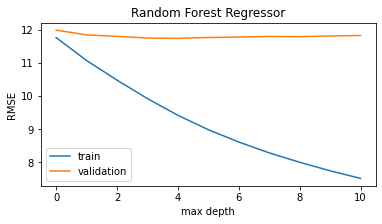

In [339]:
plt.figure(figsize=(6,3))
plt.plot(rmse_train, label="train")
plt.plot(rmse_val, label="validation")
plt.title("Random Forest Regressor")
plt.ylabel("RMSE")
plt.xlabel("max depth")
plt.legend();

In [340]:
# train on all training data, to run model on real test data
RF_model = RandomForestRegressor(max_depth=best_params['max_depth'],\
                                 n_estimators=best_params['n_estimators'], random_state=42)
RF_model.fit(X_train, Y_train)  

RandomForestRegressor(max_depth=5, n_estimators=300, random_state=42)

# Test Data Prediction

In [341]:
test_dataset = test_dataset.drop(["pop"], axis=1)

In [342]:
#feature scaling on test dataset
test_dataset_arr=test_dataset.values
test_dataset_arr[:,:9]=scaler.transform(test_dataset_arr[:,:9]) 

In [343]:
linear_regression=False
svm_regression=False
rf_regression=True

Y_test_val=False

if linear_regression:
    Y_test = LR_model.predict(test_dataset_arr)
    file_name="y_pred_LR.csv"
    Y_test_val=True
if svm_regression:
    Y_test = SVR_model.predict(test_dataset_arr)
    file_name="y_pred_SVR.csv"
    Y_test_val=True
if rf_regression:   
    Y_test = RF_model.predict(test_dataset_arr)
    file_name="y_pred_RF.csv"
    Y_test_val=True

In [344]:
# save predictions to csv file for uploading to kaggle
def save_y_pred(X_TEST_Id, y_pred_test, file_name):
  with open(file_name, 'w') as f:
    f.write("Id," + "pop\n")
    for ii in range(len(y_pred_test)):
      f.write(str(X_TEST_Id[ii]) + ",")
      f.write(str(y_pred_test[ii])+"\n")

In [346]:
if Y_test_val:
    TEST_Id= test_df.iloc[:,:1].values
    TEST_Id=TEST_Id.flatten()
    TEST_Id=list(TEST_Id)
    y_test_pred=list(Y_test)
    save_y_pred(TEST_Id, y_test_pred, file_name)